In [355]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import shap
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import plotly.express as px



from catboost import CatBoostRegressor

import random
random.seed(42)  # For reproducibility

In [356]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [384]:
feature_columns = [
        'position', 'cumulative_distance_travelled',

        'distance_to_leader',
         'speed_1s','acceleration_1s', 
       
#        'speed_1s_lag1', 'speed_1s_lag2', 'speed_1s_lag3', 
       
#        'acceleration_1s_lag1','acceleration_1s_lag2', 'acceleration_1s_lag3',

        'distance_to_leader_lag1', 'distance_to_leader_lag2', 'distance_to_leader_lag3',
        'remaining_distance',
        'leader_remaining_distance',
        'probability'
        ] 
        
        # 'curve'] # from the updated column

target = ['target_variable']

In [385]:
folder_path = 'data/horse-tracking-data-features'
derby_path = 'data/big-data-derby-2022'
# List to store filenames and paths
def get_files(folder_path):
    file_list = []
    race_list = []
    # Iterate through the folder
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):  # Check if the file is a CSV
                full_path = os.path.join(root, file)
                file_list.append(full_path)
                race_list.append(file.split('.')[0])

    # print(file_list)
    # print(race_list)
    return file_list, race_list


def train_test_file_split(file_list):
    random.shuffle(file_list)

    split_index = int(0.8 * len(file_list))
    train_files = file_list[:split_index]
    test_files = file_list[split_index:]

    print(f"Total Files : {len(file_list)}")
    print(f"Number of training files: {len(train_files)}")
    print(f"Number of testing files: {len(test_files)}")

    return train_files, test_files


def get_dataframes(train_files, test_files):
    train_df = []
    test_df = []

    # Load and combine training data
    for file in tqdm(train_files):
        data = pd.read_csv(file)  # Adjust the function if needed (e.g., read_parquet for other formats)
        train_df.append(data)

    train_df = pd.concat(train_df, ignore_index=True)

    # Load and combine testing data
    for file in tqdm(test_files):
        data = pd.read_csv(file)
        test_df.append(data)

    test_df = pd.concat(test_df, ignore_index=True)

    # Remove after race columns
    train_df = train_df[train_df['is_race_going']]
    test_df = test_df[test_df['is_race_going']]

    

    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}")

    return train_df, test_df


# def get_X_y_splits(train_df, test_df):
#     X_train = train_df[feature_columns]
#     y_train = train_df[target]

#     X_test = test_df[feature_columns]
#     y_test = test_df[target]

#     print(f"X_train shape: {X_train.shape}")
#     print(f"X_test shape: {X_test.shape}")
#     print(f"y_train shape: {y_train.shape}")
#     print(f"y_test shape: {y_test.shape}")
#     return X_train, X_test, y_train, y_test

In [386]:
def get_data_combine(folder_path):
    file_list, race_list = get_files(folder_path)
    train_files, test_files = train_test_file_split(file_list)
    train_df, test_df = get_dataframes(train_files, test_files)
    return train_df, test_df

train_df, test_df = get_data_combine(folder_path)


Total Files : 1993
Number of training files: 1594
Number of testing files: 399


  0%|          | 0/1594 [00:00<?, ?it/s]

100%|██████████| 399/399 [00:03<00:00, 124.10it/s]


Training data shape: (3716407, 39)
Testing data shape: (909496, 39)


In [387]:
train_df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,easting,northing,unique_id,...,distance_to_leader_lag1,distance_to_leader_lag2,distance_to_leader_lag3,remaining_distance,is_race_going,final_positions,leader_remaining_distance,target_variable,probability,curve
0,SAR,2019-08-01,6,1,1,43.072410,-73.770433,600102.730636,4.769589e+06,SAR_2019-08-01_6,...,0.000000,0.000000,0.000000,1810.512000,True,3.0,1808.733867,0.000000,0.196821,0
1,SAR,2019-08-01,6,1,2,43.072410,-73.770432,600102.799949,4.769589e+06,SAR_2019-08-01_6,...,1.778133,0.000000,0.000000,1810.512000,True,3.0,1808.563705,0.000553,0.196821,0
2,SAR,2019-08-01,6,1,3,43.072407,-73.770439,600102.278082,4.769589e+06,SAR_2019-08-01_6,...,1.948295,1.778133,0.000000,1809.982841,True,3.0,1808.237341,0.002765,0.196821,0
3,SAR,2019-08-01,6,1,4,43.072403,-73.770449,600101.462885,4.769589e+06,SAR_2019-08-01_6,...,1.745500,1.948295,1.778133,1809.022712,True,3.0,1807.489539,0.002766,0.196821,0
4,SAR,2019-08-01,6,1,5,43.072398,-73.770462,600100.399473,4.769588e+06,SAR_2019-08-01_6,...,1.533173,1.745500,1.948295,1807.834328,True,3.0,1806.414329,0.001661,0.196821,0


In [388]:
# def get_updated_remaining_distance(group):
#     # one race worth of data
#     first_position_data = group[group['position']==1]
#     first_position_data = first_position_data.sort_values("trakus_index")
#     total_distance_covered_by_winner = first_position_data['cumulative_distance_travelled'].values[-1]
#     group['remaining_distance'] = total_distance_covered_by_winner-group['cumulative_distance_travelled']
#     return group

# def get_updated_leader_remaining_distance(group):
#     # one race worth of data
#     first_position_data = group[group['position']==1]
#     total_distance_covered_by_winner = first_position_data['cumulative_distance_travelled'].values[0]

#     group['leader_remaining_distance'] = total_distance_covered_by_winner

#     return group

# def calculate_distance_to_leader(group):
#     # Identify the horse at position 1
#     leader = group[group['position'] == 1]
#     if not leader.empty:
#         leader_distance = leader['cumulative_distance_travelled'].values[0]
#         # Calculate distance to the leader for all horses
#         group['distance_to_leader'] =  leader_distance - group['cumulative_distance_travelled']
#     else:
#         group['distance_to_leader'] = None  # Handle cases with no leader
#     return group



# train_df = train_df.groupby('unique_id').apply(get_updated_remaining_distance)
# train_df.reset_index(drop=True, inplace=True)

# train_df = train_df.groupby('trakus_index').apply(get_updated_leader_remaining_distance)
# train_df.reset_index(drop=True, inplace=True)


# test_df = test_df.groupby('unique_id').apply(get_updated_remaining_distance)
# test_df.reset_index(drop=True, inplace=True)

# test_df = test_df.groupby('trakus_index').apply(get_updated_leader_remaining_distance)
# test_df.reset_index(drop=True, inplace=True)



# train_df = train_df.groupby('trakus_index').apply(calculate_distance_to_leader)
# train_df.reset_index(drop=True, inplace=True)

# test_df = test_df.groupby('trakus_index').apply(calculate_distance_to_leader)
# test_df.reset_index(drop=True, inplace=True)




In [389]:
train_df.columns, test_df.columns.shape

(Index(['track_id', 'race_date', 'race_number', 'program_number',
        'trakus_index', 'latitude', 'longitude', 'easting', 'northing',
        'unique_id', 'cumulative_distance_travelled', 'position',
        'distance_to_leader', 'speed_0.25s', 'speed_1s', 'acceleration_0.25s',
        'acceleration_1s', 'speed_0.25s_lag1', 'speed_0.25s_lag2',
        'speed_0.25s_lag3', 'acceleration_0.25s_lag1',
        'acceleration_0.25s_lag2', 'acceleration_0.25s_lag3', 'speed_1s_lag1',
        'speed_1s_lag2', 'speed_1s_lag3', 'acceleration_1s_lag1',
        'acceleration_1s_lag2', 'acceleration_1s_lag3',
        'distance_to_leader_lag1', 'distance_to_leader_lag2',
        'distance_to_leader_lag3', 'remaining_distance', 'is_race_going',
        'final_positions', 'leader_remaining_distance', 'target_variable',
        'probability', 'curve'],
       dtype='object'),
 (39,))

In [390]:
# for prog_num in race_data['program_number'].unique():

#     horse_data = race_data[race_data['program_number']==prog_num]
#     final_distance_to_leader = list(horse_data['distance_to_leader'])[-1]
#     horse_data['distance_differences'] = horse_data['distance_to_leader'] - final_distance_to_leader

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calculate_leader_differences_horse(group):
    # group is of a horse data
    group = group.sort_values('trakus_index')
    final_distance_to_leader = list(group['distance_to_leader'])[-1]
    group['distance_differences'] = group['distance_to_leader'] - final_distance_to_leader
    # if distance_differences is negetive, ,make it 0
    group['distance_differences'] = group['distance_differences'].clip(lower=0)
    # normalize the distance differences to range of 0 to 1

    group['distance_differences'] = np.where(
        group['leader_remaining_distance'] < 0, 
        1,  # Set to 1 for negative leader_remaining_distance
        np.log1p(group['distance_differences']) / group['leader_remaining_distance']  # Normal case
    )
    # return group
    # group['distance_differences'] = group['distance_differences']/group['leader_remaining_distance']    

    return group

def calculate_leader_differences_race(race_data):
    race_data = race_data.sort_values('trakus_index')
    race_data['program_number'] = race_data['program_number'].astype(str).str.strip()
    race_data = race_data.groupby('program_number').apply(calculate_leader_differences_horse)
    return race_data


In [391]:
train_df = train_df.groupby('unique_id').apply(calculate_leader_differences_race)
test_df = test_df.groupby('unique_id').apply(calculate_leader_differences_race)


train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True, drop=True)

In [392]:
train_df.shape, train_df.columns

((3716407, 40),
 Index(['track_id', 'race_date', 'race_number', 'program_number',
        'trakus_index', 'latitude', 'longitude', 'easting', 'northing',
        'unique_id', 'cumulative_distance_travelled', 'position',
        'distance_to_leader', 'speed_0.25s', 'speed_1s', 'acceleration_0.25s',
        'acceleration_1s', 'speed_0.25s_lag1', 'speed_0.25s_lag2',
        'speed_0.25s_lag3', 'acceleration_0.25s_lag1',
        'acceleration_0.25s_lag2', 'acceleration_0.25s_lag3', 'speed_1s_lag1',
        'speed_1s_lag2', 'speed_1s_lag3', 'acceleration_1s_lag1',
        'acceleration_1s_lag2', 'acceleration_1s_lag3',
        'distance_to_leader_lag1', 'distance_to_leader_lag2',
        'distance_to_leader_lag3', 'remaining_distance', 'is_race_going',
        'final_positions', 'leader_remaining_distance', 'target_variable',
        'probability', 'curve', 'distance_differences'],
       dtype='object'))

In [393]:
# scale to range of 0 to 1

In [394]:
# train_df_save = train_df
# test_df_save = test_df

In [395]:
train_df['distance_differences'].describe()

count    3.716407e+06
mean     2.373314e-02
std      4.697088e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.053071e-03
max      4.739576e+02
Name: distance_differences, dtype: float64

In [396]:
def get_X_y_splits(train_df, test_df):
    X_train = train_df[feature_columns]
    y_train = train_df[target]

    X_test = test_df[feature_columns]
    y_test = test_df[target]
    return X_train, X_test, y_train, y_test


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

def scale_data(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()

    # Normalize
    X_train_scaled = scaler.fit_transform(X_train)  # NumPy array
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    y_train['distance_differences'] = y_train['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)
    y_test['distance_differences'] = y_test['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [397]:
target = ['distance_differences']
X_train, X_test, y_train, y_test = get_X_y_splits(train_df, test_df)
X_train_scaled, X_test_scaled, y_train, y_test , scalar= scale_data(X_train, X_test, y_train, y_test)


/var/folders/b9/bslcg5p949522myh51h02xt40000gn/T/ipykernel_10838/4026638938.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['distance_differences'] = y_train['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)
/var/folders/b9/bslcg5p949522myh51h02xt40000gn/T/ipykernel_10838/4026638938.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['distance_differences'] = y_test['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)


In [398]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((3716407, 11), (909496, 11), (3716407, 1), (909496, 1))

In [401]:
X_train.columns

Index(['position', 'cumulative_distance_travelled', 'distance_to_leader',
       'speed_1s', 'acceleration_1s', 'distance_to_leader_lag1',
       'distance_to_leader_lag2', 'distance_to_leader_lag3',
       'remaining_distance', 'leader_remaining_distance', 'probability'],
      dtype='object')

In [402]:
y_train['distance_differences'].describe()

count    3.716407e+06
mean     2.280607e-02
std      1.448473e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.053071e-03
max      9.999990e-01
Name: distance_differences, dtype: float64

### Model Training

In [403]:
def train_it(model, X_train_scaled, y_train):
    model.fit(X_train_scaled,y_train)
    return model

def predict_this(model, X):
    x_pred = pd.DataFrame()
    x_pred['pred'] = model.predict(X)
    return x_pred['pred'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)

def get_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [404]:
def training_arc(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model = train_it(model, X_train_scaled, y_train)
    y_train_pred = predict_this(model, X_train_scaled)
    y_test_pred = predict_this(model, X_test_scaled)

    # rmse
    train_rmse = get_rmse(y_train[target], y_train_pred)
    test_rmse = get_rmse(y_test[target], y_test_pred)
    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)

    return model, train_rmse, test_rmse
    

In [405]:
model = XGBRegressor(n_estimators=100, learning_rate=0.01, random_state=42, max_depth = 10)


In [406]:
model, _, _ = training_arc(model, X_train_scaled, X_test_scaled, y_train, y_test)


Train RMSE:  0.05888518112671878
Test RMSE:  0.05613985395693584


### Bernoulli

In [541]:
# Do bernoulli here



def plotter(win_prob, rank_, remain_, race_name, save_folder):

    base_name = os.path.splitext(race_name)[0]  # Removes the file extension
    file_name = f"{base_name}.png"
    file_name = file_name.split("/")[-1]

    save_path = os.path.join(save_folder, file_name)


    unique_program_numbers = win_prob.columns  # Assuming `program_number` is the column name in the DataFrame
    color_palette = sns.color_palette("Set2", n_colors=len(unique_program_numbers))  # Choose a color palette with enough colors
    color_map = {program_number: color_palette[i] for i, program_number in enumerate(unique_program_numbers)}

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=False)

    df_win = win_prob.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='win_probability')

    df_win['smooth_win_probability'] = df_win.groupby('program_number')['win_probability'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    # Plot 1: Win Probabilities

    sns.lineplot(
        data=df_win, 
        x='trakus_index', 
        y='smooth_win_probability', 
        hue='program_number', 
        palette=color_map,
        ax=axes[0]
    )
    axes[0].set_title("Win Probabilities Over Time")
    axes[0].set_xlabel("Time (Trakus Index)")
    axes[0].set_ylabel("Win Probability")
    axes[0].legend(title="Program Number")

    df_rank = rank_.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='position')
    


    
    df_rank['smooth_position'] = df_rank.groupby('program_number')['position'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
    )

    # Plot 2: Positions
    sns.lineplot(
        data=df_rank, 
        x='trakus_index', 
        y='smooth_position', 
        hue='program_number', 
        palette=color_map,
        ax=axes[1]
    )
    axes[1].set_title("Positions Over Time")
    axes[1].set_xlabel("Time (Trakus Index)")
    axes[1].set_ylabel("Position")
    axes[1].legend(title="Program Number")


    df_remaining_dist = remain_.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='distance_to_leader')

    df_remaining_dist['program_number'] = df_remaining_dist['program_number'].astype('string')

    # Plot 3: Distance to Leader
    sns.lineplot(
        data=df_remaining_dist, 
        x='trakus_index', 
        y='distance_to_leader', 
        hue='program_number', 
        palette=color_map,
        ax=axes[2]
    )
    axes[2].set_title("Distance to Leader Over Time")
    axes[2].set_xlabel("Time (Trakus Index)")
    axes[2].set_ylabel("Distance to Leader")
    axes[2].legend(title="Program Number")

    fig.suptitle(race_name)

    # Adjust layout
    # plt.tight_layout()
    # print("Saving image to : ", save_path)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

def monte_carlo_horse_race_smooth(remain_, pred_, rank_, dist_, total_race_distance):
    # Number of Monte Carlo simulations
    n_simulations = 1
    size = 1000  # Number of simulations per iteration
    counter = 4
    win_prob = pd.DataFrame(index=pred_.index, columns=pred_.columns)

    error_counter = 0
    intervals = range(5,105,5)
    data = [0]*20
    interval_winning_proability_info = pd.DataFrame(index=intervals, columns=['trakus_index','winning_horse'])

    # Monte Carlo simulation loop
    for sim in range(n_simulations):
        # Temporary DataFrame for storing simulated ranks in this iteration
        cur_win_prob = pd.DataFrame(index=range(size), columns=pred_.columns)
        interval = 5
        # Simulate for each race
        for i, row in pred_.iterrows():
            # Get the ranks for the current track index
            rank_for_index = rank_.loc[i]  # Program numbers as index, ranks as values
            rank_for_index = rank_for_index.sort_values()  # Ensure ranks are sorted

            dist_for_index = dist_.loc[i]
            dist_for_index =  dist_for_index.sort_values()

            # Iterate over the horses based on their program number
            for fp in pred_.columns:
                # Skip if horse has finished
                if remain_.loc[i][fp] < 0:
                    cur_win_prob[fp] = [1] * size
                    continue

                # Get the program number of the current horse at trakus_index
                current_program_number = str(fp)  # Convert fp to string
                current_rank = dist_for_index.loc[current_program_number]

                # Poisson distribution for rank differences
                lambda_ = abs(remain_.loc[i][fp] * row[fp])  # Expected value

                # Two-step Monte Carlo simulation
                # 1. Poisson distribution for rank differences
                try:
                    fp_rank_diff = np.random.poisson(lambda_, size)

                    # make plots for fp_rank_diff
                    if (i==150):
                        # make random chance (not everytime)
                        # plot fp_rank_diff
                        # decrease counter
                        # Print necessary stats alogn plot
                        # like trakus index, horse number, horse position, distance to leader at this point
                        # if np.random.rand() < 0.1:  # 10% chance of plotting
                            # Plot histogram for fp_rank_diff
                        plt.figure(figsize=(8, 6))
                        plt.hist(fp_rank_diff, edgecolor='k', alpha=0.7)
                        plt.axvline(x=current_rank, color='red', linestyle='--', linewidth=2, label=f'Distance to leader')
                        plt.title(f'Histogram of Distance Coverable at Trakus Index {i} for Horse {fp}')
                        plt.xlabel('Distance Coverable')
                        plt.ylabel('Frequency')
                        plt.grid(True)
                        plt.show()  # Show the plot
                        print(f"Trakus Index: {i}, Horse Number: {fp}")
                        print(f"Race Rank: {rank_.loc[i][fp]}, Remaining Distance: {remain_.loc[i][fp]}")
                        print(f"Distance to Leader: {current_rank}")
                        counter -= 1
                        





                    # get some random graphs here
                    # things to note trakus index, race number
                except Exception as e:
                    # print(f"Exception occurred: {e}")
                    # print("Lambda is : ", lambda_)
                    # print("Rem : ", remain_.loc[i][fp] )
                    # print("row[fp] : ", row[fp])
                    error_counter +=1
                    break
                # 2. Calculate predicted ranks (First to finish is the winner)
                pred_rank = current_rank - fp_rank_diff

                # Store simulation results with weighting
                smoothed_probs = np.sum(pred_rank <= 0) / size  # Update the probability with weight

                # Aggregate win probabilities
                if sim == 0:
                    # Initialize on first iteration
                    win_prob.loc[i, fp] = smoothed_probs
                else:                               
                    # Accumulate probabilities      
                    win_prob.loc[i, fp] += smoothed_probs

                # check if at this point the leader passed a interval mark
                if rank_.loc[i][fp] == 1:
                    if (((total_race_distance - remain_.loc[i][fp])*100/total_race_distance ) >= interval):
                        # print("Total Race_distance: ", total_race_distance)
                        # print(f"Remainging : {remain_.loc[i][fp]}")
                        # print(f"Leader % race complete : {((total_race_distance - remain_.loc[i][fp])*100/total_race_distance )}")
                        # print("Probs : ", smoothed_probs)
                    

                        interval_winning_proability_info.loc[interval]['trakus_index'] = i
                        interval_winning_proability_info.loc[interval]['winning_horse'] = fp
                        interval+=5
                # store probabilitity of leader at that interval


    # Normalize probabilities across all horses
    win_prob = win_prob.divide(n_simulations)
    #win_prob = win_prob.divide(win_prob.sum(axis=1), axis=0)
    # Fill NaN with 0
    win_prob = win_prob.fillna(0)

    # Calculate row-wise sums
    row_sums = win_prob.sum(axis=1)

    # Normalize only where the sum is non-zero
    win_prob = win_prob.divide(row_sums.replace(0, np.nan), axis=0)

    interval_winning_proability = pd.DataFrame(index=intervals, columns=['win_probability'])

    # print("Info Matrix:")
    # print(interval_winning_proability_info)

    for i, row in interval_winning_proability_info.iterrows():

        try:
            interval_winning_proability.loc[i]['win_probability'] = win_prob.loc[row['trakus_index']][row['winning_horse']]
        except Exception as e:
            if i==100:
                interval_winning_proability.loc[i]['win_probability'] = win_prob.loc[len(win_prob)-1].max() if win_prob.loc[len(win_prob)-1].max() != np.nan else 100
            elif i>5:
                interval_winning_proability.loc[i]['win_probability'] = interval_winning_proability.loc[i-5]['win_probability']
            else:
                interval_winning_proability.loc[i]['win_probability'] = 0.1

    if error_counter > 0:
        print(f"Warning: {error_counter} horse(s) had problems calculating their rank difference, and their probabilities were not calculated.")

    # print(f"Race win Probabilitiy: {interval_winning_proability}")
    return win_prob, interval_winning_proability


def monte_carlo_wrapper(race_data):
    # the reace I cwill get here will be after passing it to model already
    race_data.sort_values('trakus_index', inplace=True)
    race_data = race_data.reset_index()

    total_race_distance = race_data.loc[0,'cumulative_distance_travelled'] + race_data.loc[0,'remaining_distance']

    # convert to string representation
    race_data['program_number'] = race_data['program_number'].astype(str).str.strip()
    race_data['percent_race_completed'] = race_data['cumulative_distance_travelled']/total_race_distance*100

    # brenoulli now
    size = 1000
    dist_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_to_leader')
    remain_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='leader_remaining_distance')
    pred_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_differences')



    rank_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='position')

    null_cout = remain_.isnull().sum()
    if null_cout.any():
        print(f"Null Vals : {null_cout} found")
        
    win_prob, interval_wins = monte_carlo_horse_race_smooth(remain_, pred_, rank_, dist_, total_race_distance)
    return win_prob, rank_, interval_wins

def bernoulli_race(race_data):
    # dataframe containing one race worth of data
    # for each trakus index, calculate prob for each hors
    # return dataframe
    
    # the reace I cwill get here will be after passing it to model already
    race_data.sort_values('trakus_index', inplace=True)
    race_data = race_data.reset_index()

    # convert to string representation
    race_data['program_number'] = race_data['program_number'].astype(str).str.strip()

    # brenoulli now
    size = 1000
    rank_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_to_leader')
    remain_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='leader_remaining_distance')
    pred_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_differences')
    pos_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='position')


    win_prob = pred_.copy() 

    total_rows = win_prob.shape[0]
    error_rows = 0

    for i, row in pred_.iterrows():
        cur_win_prob = pd.DataFrame(index=range(size))
        for fp in pred_.columns:
            
            if remain_.loc[i][fp] < 0:
                cur_win_prob[fp] = [1]*1000
                continue
            try:
               
                fp_dist_diff = np.random.binomial(remain_.loc[i][fp], row[fp], size)
            except Exception as e:
                # print("Error occurred during Bernoulli race calculation for race. , error : " + str(e))
                # print current variable values
                # print(f"Status: Rem : {remain_.loc[i][fp]} || Target: {row[fp]}")
                error_rows += 1
            
            
            pred_rank = rank_.loc[i][fp] - fp_dist_diff
            cur_win_prob[fp] = pred_rank
        # cur_win_prob = cur_win_prob.rank(method='min', axis=1)
        for fp in pred_.columns:
            win_prob.loc[i, fp] = sum(cur_win_prob[fp]<=0) / size

    # norm
    win_prob = win_prob.divide(win_prob.sum(axis=1), axis=0)

    # if error_rows > 0:
        # print(f"Error occurred {error_rows} times during Bernoulli race calculation. ({error_rows/total_rows} %)")

    return win_prob, rank_



def bernoulli_super(file_list, model, scalar,save_folder):
    # multiple files
    # read each file, pass through model to predict target
    # take target df for the race, pass to bernoulli_race to get probabilities for that, store. 

    os.makedirs(save_folder, exist_ok=True)

    data = [0]*20
    average_interval_win_prob = pd.DataFrame(index = range(5,105,5), data= data,columns=['win_probability'])
    # print("AVG, Win Prob")
    # print(average_interval_win_prob)

    for file in tqdm(file_list):
        # print("For Race : " + str(file))
        race_data = pd.read_csv(file)
        race_data = race_data[race_data['is_race_going']]
        race_features = scalar.transform(race_data[feature_columns])
        race_data['distance_differences'] = model.predict(race_features)
        race_data['distance_differences'] = race_data['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)
        # pass race_data to bernoulli race function
        # win_prob, rank_ = bernoulli_race(race_data)
        # print("For Race : " + str(file))
        win_prob, rank_,interval_wins = monte_carlo_wrapper(race_data)
        average_interval_win_prob['win_probability'] = average_interval_win_prob['win_probability']+interval_wins['win_probability']

        remain_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_to_leader')

        # plot probabilities for that race
        plotter(win_prob, rank_, remain_, file, save_folder) 
        # return win_prob
    
    average_interval_win_prob['win_probability'] = average_interval_win_prob['win_probability']/len(file_list)
    return average_interval_win_prob



### Create Plots

0

In [488]:
file_list, race_list = get_files(folder_path)
train_set, test_set= train_test_file_split(file_list)

test_set = test_set

Total Files : 1993
Number of training files: 1594
Number of testing files: 399


In [463]:
file_list

['data/horse-tracking-data-features/BEL_2019-09-06_6.csv',
 'data/horse-tracking-data-features/SAR_2019-07-11_1.csv',
 'data/horse-tracking-data-features/SAR_2019-08-16_4.csv',
 'data/horse-tracking-data-features/SAR_2019-07-26_8.csv',
 'data/horse-tracking-data-features/BEL_2019-09-14_10.csv',
 'data/horse-tracking-data-features/AQU_2019-03-02_4.csv',
 'data/horse-tracking-data-features/SAR_2019-07-14_7.csv',
 'data/horse-tracking-data-features/BEL_2019-06-22_1.csv',
 'data/horse-tracking-data-features/AQU_2019-12-08_8.csv',
 'data/horse-tracking-data-features/BEL_2019-07-07_2.csv',
 'data/horse-tracking-data-features/BEL_2019-06-28_5.csv',
 'data/horse-tracking-data-features/BEL_2019-09-21_7.csv',
 'data/horse-tracking-data-features/AQU_2019-03-23_1.csv',
 'data/horse-tracking-data-features/BEL_2019-06-27_9.csv',
 'data/horse-tracking-data-features/BEL_2019-05-27_10.csv',
 'data/horse-tracking-data-features/SAR_2019-07-18_8.csv',
 'data/horse-tracking-data-features/SAR_2019-08-03_8.c

In [530]:
file_list.sort()

In [ ]:
file_list

In [532]:
files_to_check= [
    'data/horse-tracking-data-features/AQU_2019-11-30_7.csv'
]

In [540]:
test_set[:1]

['data/horse-tracking-data-features/SAR_2019-09-01_2.csv']

  0%|          | 0/1 [00:00<?, ?it/s]

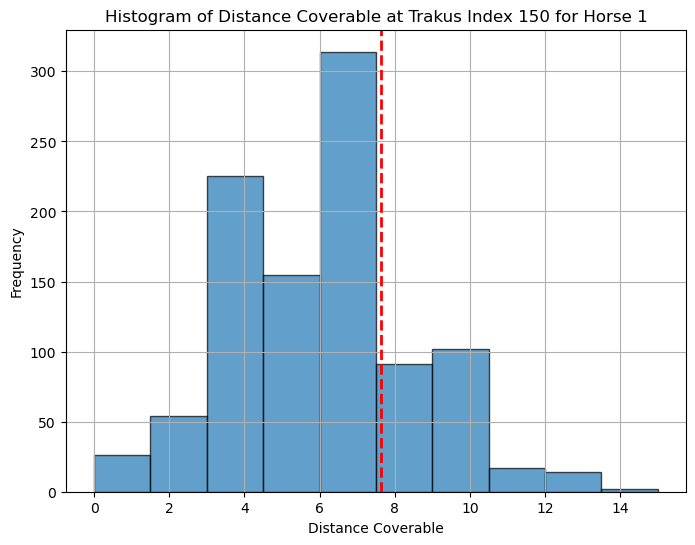

Trakus Index: 150, Horse Number: 1
Race Rank: 5.0, Remaining Distance: 679.5887123687522
Distance to Leader: 7.63923845246768


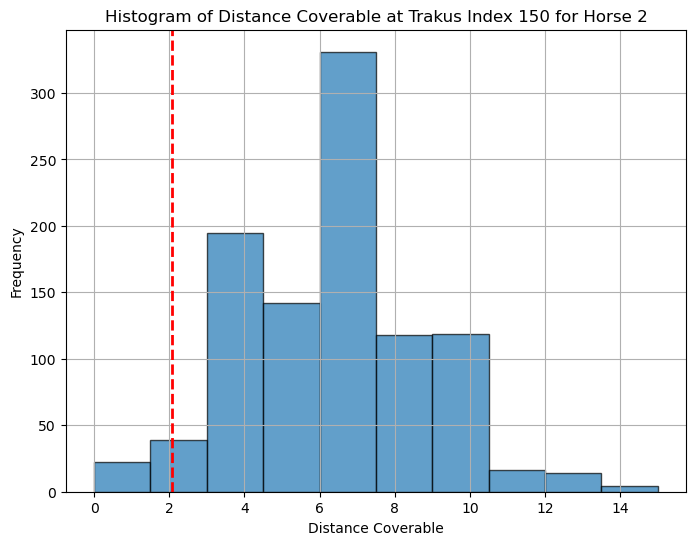

Trakus Index: 150, Horse Number: 2
Race Rank: 3.0, Remaining Distance: 679.5887123687522
Distance to Leader: 2.082428775934659


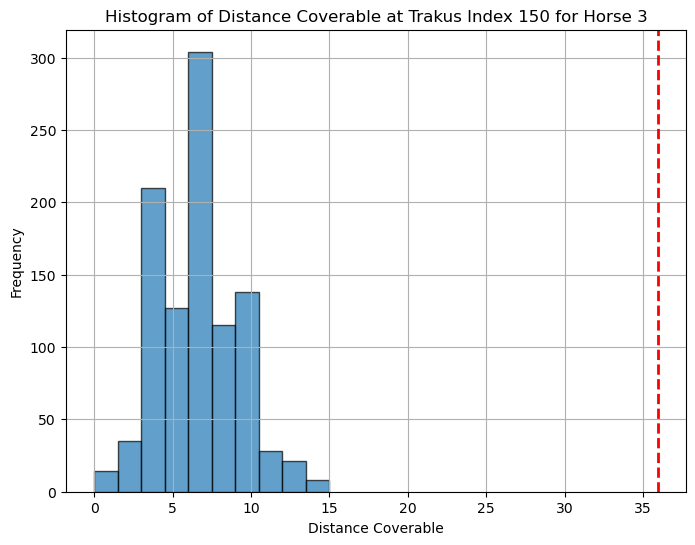

Trakus Index: 150, Horse Number: 3
Race Rank: 7.0, Remaining Distance: 679.5887123687522
Distance to Leader: 35.92378917837925


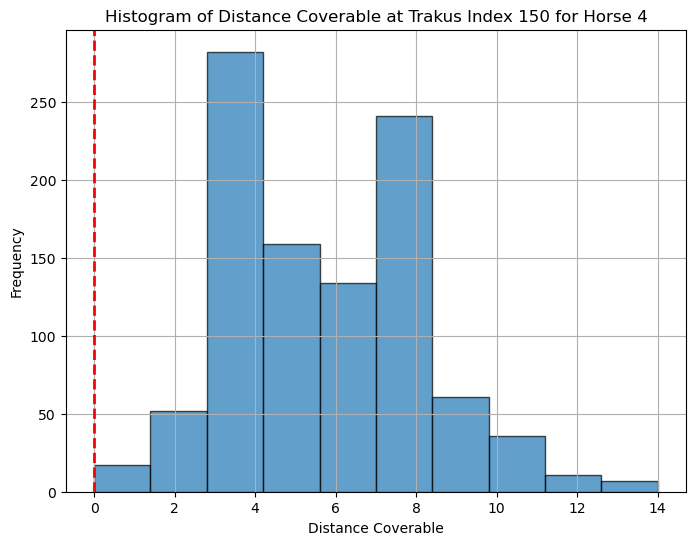

Trakus Index: 150, Horse Number: 4
Race Rank: 1.0, Remaining Distance: 679.5887123687522
Distance to Leader: 0.0


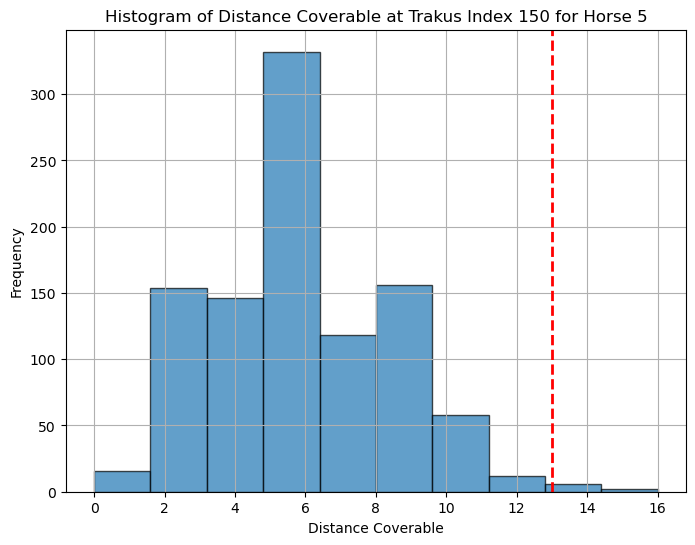

Trakus Index: 150, Horse Number: 5
Race Rank: 6.0, Remaining Distance: 679.5887123687522
Distance to Leader: 13.004060234437816


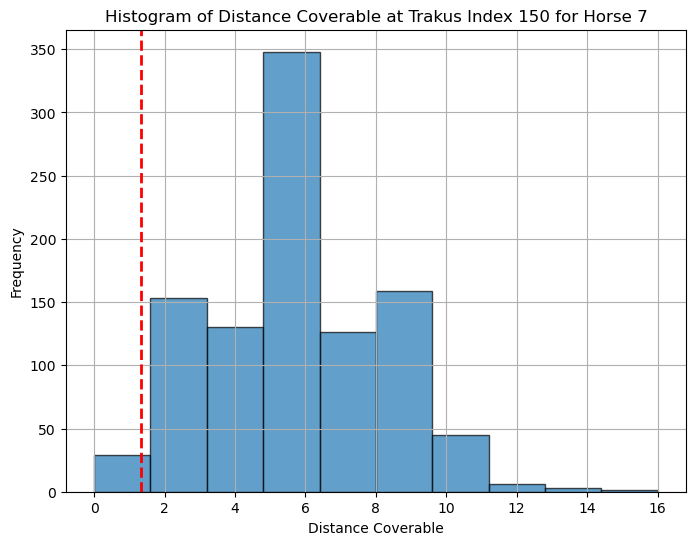

Trakus Index: 150, Horse Number: 7
Race Rank: 2.0, Remaining Distance: 679.5887123687522
Distance to Leader: 1.332756440155208


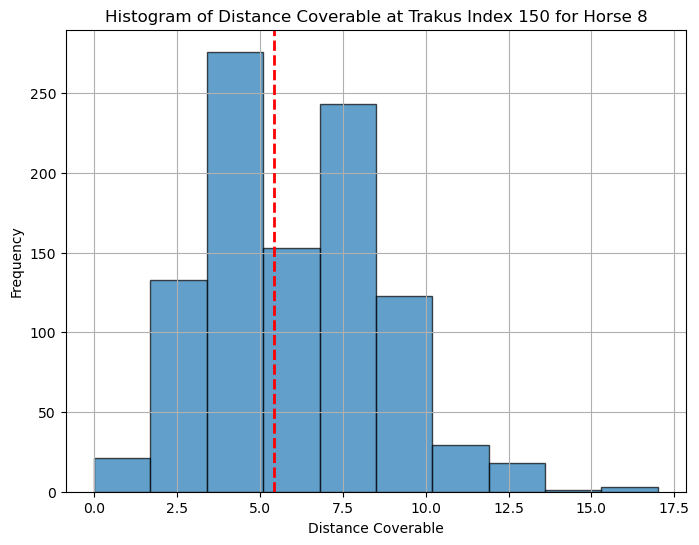

Trakus Index: 150, Horse Number: 8
Race Rank: 4.0, Remaining Distance: 679.5887123687522
Distance to Leader: 5.432552909685455


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


In [542]:
avg_win_probs = bernoulli_super(test_set[:1], model, scalar,save_folder="output-plots/distance_differences-full-11-features-check-poisson-graphs")

In [533]:
avg_win_probs = bernoulli_super(files_to_check, model, scalar,save_folder="output-plots/distance_differences-full-11-features-final-proper-colored")

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


### Some Good Plots

sample_plots = [
'data/horse-tracking-data-features/AQU_2019-11-30_7.csv',
'data/horse-tracking-data-features/AQU_2019-12-20_7.csv',
'data/horse-tracking-data-features/BEL_2019-04-26_5.csv',
'data/horse-tracking-data-features/BEL_2019-05-02_3.csv',
'data/horse-tracking-data-features/BEL_2019-05-04_7.csv',
'data/horse-tracking-data-features/BEL_2019-05-10_3.csv',
'data/horse-tracking-data-features/BEL_2019-09-19_5.csv',

'data/horse-tracking-data-features/SAR_2019-07-19_2.csv',
'data/horse-tracking-data-features/SAR_2019-07-24_6.csv',
'data/horse-tracking-data-features/SAR_2019-08-02_1.csv',
]







In [535]:
sample_plots = [
'data/horse-tracking-data-features/AQU_2019-11-30_7.csv',
'data/horse-tracking-data-features/AQU_2019-12-20_7.csv',
'data/horse-tracking-data-features/BEL_2019-04-26_5.csv',
'data/horse-tracking-data-features/BEL_2019-05-02_3.csv',
'data/horse-tracking-data-features/BEL_2019-05-04_7.csv',
'data/horse-tracking-data-features/BEL_2019-05-10_3.csv',
'data/horse-tracking-data-features/BEL_2019-09-19_5.csv',

'data/horse-tracking-data-features/SAR_2019-07-19_2.csv',
'data/horse-tracking-data-features/SAR_2019-07-24_6.csv',
'data/horse-tracking-data-features/SAR_2019-08-02_1.csv',
]


In [536]:
avg_win_probs = bernoulli_super(sample_plots, model, scalar,save_folder="output-plots/sample_plots")

100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


In [528]:
avg_win_probs

,win_probability
5,0.14704
10,0.166622
15,0.189914
20,0.213
25,0.233174
30,0.250669
35,0.266961
40,0.283945
45,0.303488
50,0.327941


In [491]:
avg_win_probs.loc[100]=100
avg_win_probs

,win_probability
5,0.147066
10,0.166574
15,0.19001
20,0.212885
25,0.233109
30,0.250637
35,0.267135
40,0.283926
45,0.303812
50,0.327828


In [492]:
avg_win_probs.to_csv("Average_Win_Proabilities_At_Intervals_full_399_races_test_set.csv")

In [ ]:

data = [0.146587,0.16391,	0.186933,	0.212504,0.231814,0.254221,0.276822,0.302429,0.32944,0.355197,0.373067,0.398152,	0.430941,0.485274,0.553463,0.649932,0.708227,0.792101,0.864899,100]

average_win_probabilities = pd.DataFrame(index = range(5,105,5), columns = 'win_probability', data=data)

	
average_win_probabilities

In [544]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())


values = list(feature_important.values())
f_imp_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
f_imp_df.rename(index={'probability': 'initial_probability'}, inplace=True)

f_imp_df

,score
distance_to_leader_lag2,1096.0
distance_to_leader_lag1,1579.0
remaining_distance,2416.0
leader_remaining_distance,2632.0
position,2739.0
acceleration_1s,4148.0
distance_to_leader,4738.0
distance_to_leader_lag3,5252.0
cumulative_distance_travelled,6042.0
speed_1s,6229.0


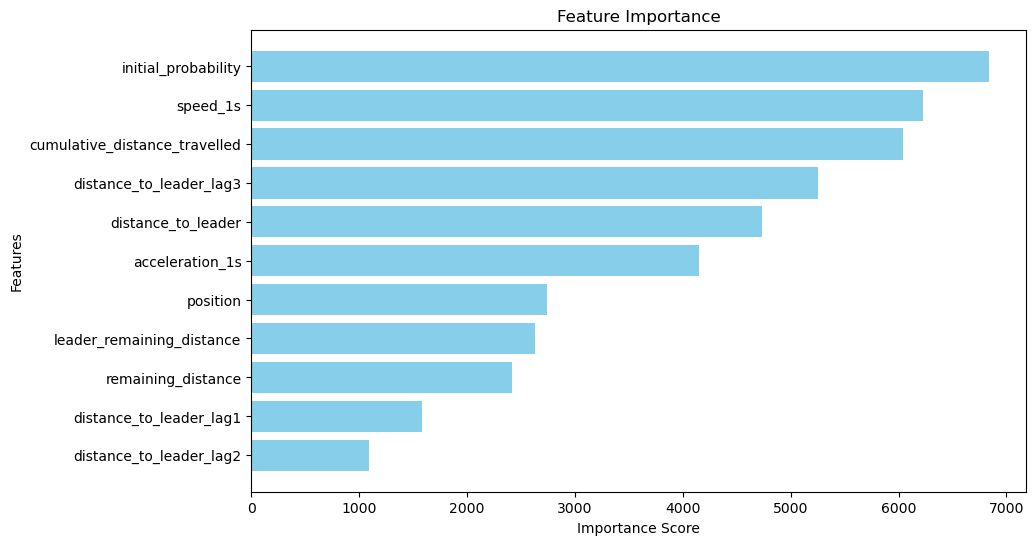

In [545]:
plt.figure(figsize=(10, 6))
plt.barh(f_imp_df.index, f_imp_df['score'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [243]:
to_check  = test_set[13]

In [244]:
to_check

'data/horse-tracking-data/AQU_2019-03-24_5.csv'

In [248]:
race_data = pd.read_csv(to_check)
race_data = race_data[race_data['is_race_going']]

In [253]:
race_data[race_data['program_number']==3][['leader_remaining_distance']]

,leader_remaining_distance
624,1205.517357
625,1205.044673
626,1204.503545
627,1203.653865
628,1202.573733
...,...
876,16.106349
877,11.862169
878,7.562315
879,3.440094


In [298]:
df = pd.DataFrame(file_list)
indx = df[df[0]== 'data/horse-tracking-data/AQU_2019-11-30_7.csv'].index
indx

Index([1633], dtype='int64')

In [299]:
file_to_check = 'data/horse-tracking-data/AQU_2019-11-30_7.csv'

In [305]:
win_prob= bernoulli_super([file_to_check], model, scalar,save_folder="output-plots/distance_differences-full-5-features-xgboost-poisson-smooth-log1p")

  0%|          | 0/1 [00:01<?, ?it/s]


In [306]:
win_prob

program_number,1,2,3,4,5,6,7
trakus_index,,,,,,,
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
5,0.142898,0.142755,0.142755,0.142898,0.142898,0.142898,0.142898
...,...,...,...,...,...,...,...
240,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
241,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
242,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [307]:
win_prob.to_csv("AQU_2019-11-30_7_probs.csv")